# Simulation Sample Preparation

In this notebook I setup the different samples I'm going to use for each experiment to test the spaceNNtime neural net.

<a name="Home3"></a>

## Contents

0. [ Library and packages ](#Lib)
1. [ Metadata Preparation ](#Met)
    + 1. [ Downsampling and Gold ](#Dow)
    + 2. [ Real ](#Rea)

<a name="Lib"></a>
## 0. Library and packages

In [1]:
import pandas as pd

%load_ext rpy2.ipython

In [2]:
%%R

library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;


<a name="Met"></a>
## 1. Metadata Preparation


<a name="Dow"></a>
### A. Downsampling and Gold




In [3]:
%%bash

mkdir -p /home/moicoll/spaceNNtime/data/europe/metadata

In [4]:
metadata = pd.read_csv("/home/moicoll/spaceNNtime/data/europe/metadata.txt", sep = "\t")

prev_metadata = metadata
for name, n in zip([1, 2, 3, 4, 5, 6, 7], [15_000, 10_000, 5_000, 1_500, 1_000, 500, 250]):
    prev_metadata = prev_metadata.sample(n=n, replace=False, random_state=1234, axis=None, ignore_index=False)
    prev_metadata.to_csv("/home/moicoll/spaceNNtime/data/europe/metadata/{}.txt".format(name), sep='\t', index=False, doublequote=False)

In [5]:
%%bash

head /home/moicoll/spaceNNtime/data/europe/metadata/1.txt

ind_id	pop	time	sampled	lat	lon	node1	node2
22333	EUR	24463	True	35.1290327524117	37.6233169117395	15824	15825
44487	EUR	2105	True	20.3047164869021	43.5672844706891	29118	29119
36478	ANA	10553	True	32.0079192307929	37.1394680565021	24092	24093
34047	ANA	12953	True	36.2979709518097	39.4480158641814	22700	22701
38827	EHG	8323	True	12.5418869819229	51.8267153434264	25466	25467
4667	OOA	45230	True	47.3616912041372	29.3017423669617	3418	3419
29805	EHG	17206	True	35.31183396654	58.7746113287844	20178	20179
23347	EHG	23502	True	44.2937770093032	55.7164362659577	16426	16427
7834	OOA	41164	True	57.7679852144354	38.0647655269939	5818	5819


In [6]:
%%bash

for name in `seq 1 7`;
    do
    wc -l /home/moicoll/spaceNNtime/data/europe/metadata/${name}.txt
done

15001 /home/moicoll/spaceNNtime/data/europe/metadata/1.txt
10001 /home/moicoll/spaceNNtime/data/europe/metadata/2.txt
5001 /home/moicoll/spaceNNtime/data/europe/metadata/3.txt
1501 /home/moicoll/spaceNNtime/data/europe/metadata/4.txt
1001 /home/moicoll/spaceNNtime/data/europe/metadata/5.txt
501 /home/moicoll/spaceNNtime/data/europe/metadata/6.txt
251 /home/moicoll/spaceNNtime/data/europe/metadata/7.txt


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Rea"></a>
### B. Real

In this experiment, I'll try to match the sampling distribution in the temporal dimention of the MesoNeo data. For that, I have explored the distribution in that axis in the real data and grouped samples in windows of 1,000 years and counted how many samples do I get for each temporal bin. I obtained the data below.

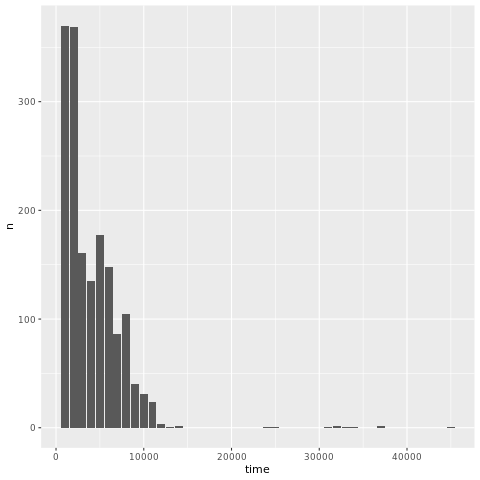

In [7]:
%%R

mesoneo_temp_bins_n = data.frame(time = c(1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,  9000, 10000, 11000, 12000, 13000, 14000, 24000, 25000, 31000, 32000, 33000, 34000, 37000, 45000),
                                 n     = c( 370,  369,  161,  135,  177,  148,   86,  105,    40,    31,    24,     3,     1,     2,     1,     1,     1,     2,     1,     1,     2,     1)) 
mesoneo_temp_bins_n %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = time, y = n))

In [8]:
%%R

mesoneo_temp_bins_n %>%
    summarize(n = sum(n))

     n
1 1662


In [9]:
%%R

metadata = read.table("/home/moicoll/spaceNNtime/data/europe/metadata/1.txt", header = T) 

metadata %>% head()

  ind_id pop  time sampled      lat      lon node1 node2
1  22333 EUR 24463    True 35.12903 37.62332 15824 15825
2  44487 EUR  2105    True 20.30472 43.56728 29118 29119
3  36478 ANA 10553    True 32.00792 37.13947 24092 24093
4  34047 ANA 12953    True 36.29797 39.44802 22700 22701
5  38827 EHG  8323    True 12.54189 51.82672 25466 25467
6   4667 OOA 45230    True 47.36169 29.30174  3418  3419


In [10]:
%%R 

mesoneo_downsampled = data.frame()

set.seed(1234)

for(t in mesoneo_temp_bins_n$time){
    n_rea = mesoneo_temp_bins_n %>% filter(time == t) %>% pull(n)
    n_sim = metadata %>% filter(t <= time, t+1000 > time) %>% nrow()
    if(n_sim < n_rea){
        mesoneo_downsampled = rbind(mesoneo_downsampled, metadata %>% filter(t <= time, t+1000 > time))
    }else{
        mesoneo_downsampled = rbind(mesoneo_downsampled, metadata %>% filter(t <= time, t+1000 > time) %>% sample_n(n_rea, replace = FALSE))
    }
                                     
}


In [11]:
%%R

mesoneo_downsampled %>%
    dim()

[1] 1499    8


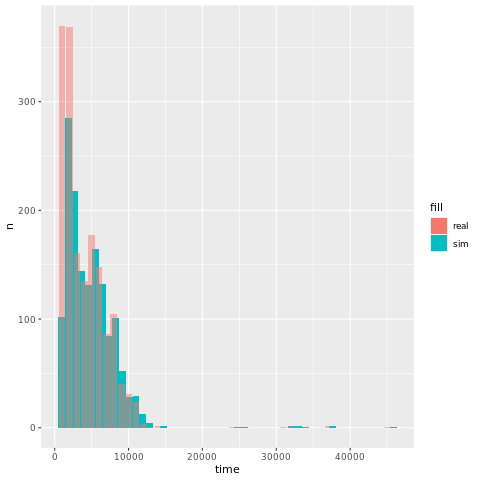

In [12]:
%%R

mesoneo_downsampled %>% 
    ggplot() +
    geom_histogram(aes(x = time, fill = "sim"), bins = 50) +
    geom_bar(data = mesoneo_temp_bins_n, stat = "identity", aes(x = time, y = n, fill = "real"), alpha = 0.5)

In [13]:
%%R

write.table(x = mesoneo_downsampled, file = "/home/moicoll/spaceNNtime/data/europe/metadata/8.txt", append = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [14]:
%%bash

head /home/moicoll/spaceNNtime/data/europe/metadata/8.txt
echo ""
head /home/moicoll/spaceNNtime/data/europe/metadata/1.txt

ind_id	pop	time	sampled	lat	lon	node1	node2
44726	EUR	1839	True	24.7323827775943	47.4840536299083	29286	29287
44743	EUR	1798	True	20.8907623356569	45.6570197191665	29304	29305
45268	EUR	1000	True	2.40486894275938	48.069668329689	29736	29737
44760	EUR	1789	True	27.3801873885939	47.800812693993	29314	29315
45189	EUR	1150	True	26.6507325099244	43.4340286541643	29646	29647
44816	EUR	1708	True	4.00431106401085	43.7140206117043	29376	29377
44795	EUR	1759	True	20.0578594259468	44.3649239898658	29346	29347
45085	EUR	1340	True	21.6612455141949	49.4515427603467	29558	29559
44693	EUR	1860	True	9.41977112554445	51.420381220628	29256	29257

ind_id	pop	time	sampled	lat	lon	node1	node2
22333	EUR	24463	True	35.1290327524117	37.6233169117395	15824	15825
44487	EUR	2105	True	20.3047164869021	43.5672844706891	29118	29119
36478	ANA	10553	True	32.0079192307929	37.1394680565021	24092	24093
34047	ANA	12953	True	36.2979709518097	39.4480158641814	22700	22701
38827	EHG	8323	True	12.5418869819229	51.8267153434264

In [15]:
%%bash

wc -l /home/moicoll/spaceNNtime/data/europe/metadata/8.txt

1500 /home/moicoll/spaceNNtime/data/europe/metadata/8.txt


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;